In [50]:
! pip install rdkit

import numpy as np
import rdkit
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

In [52]:
from google.colab import files
data=files.upload()

In [ ]:
df = pd.read_csv('drugs.csv', sep=';', on_bad_lines='skip')


In [54]:
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL253309,NaN,NaN,563.79,1.0,3.30,"3, cyclo(-L-Am7(S2Py)-Aib-L-Leu-D-Pro-)",CC(C)C[C@@H]1NC(=O)C(C)(C)NC(=O)[C@H](CCCCCSSc...,IC50,'=',...,SINGLE PROTEIN,CHEMBL1140755,1,Scientific Literature,Bioorg Med Chem,2008,NaN,NaN,NaN,NaN
1,CHEMBL269935,NaN,NaN,289.33,0.0,4.31,2,O=C(Nc1cc(-c2ccccc2)ccc1O)c1ccccc1,IC50,'>',...,SINGLE PROTEIN,CHEMBL1143185,1,Scientific Literature,Bioorg Med Chem Lett,2008,NaN,NaN,NaN,NaN
2,CHEMBL437029,NaN,NaN,521.62,2.0,5.43,56,C[C@H]1CN(c2ccc(C(=O)Nc3cc(-c4ccccc4)ccc3N)cn2...,IC50,'>',...,SINGLE PROTEIN,CHEMBL1143185,1,Scientific Literature,Bioorg Med Chem Lett,2008,NaN,NaN,NaN,NaN
3,CHEMBL3639926,NaN,NaN,411.55,0.0,4.88,BDBM110013,Cc1cc(C)c(Nc2ccc(C(=O)N(C)CCCCCCC(=O)NO)cc2)c(...,IC50,'=',...,SINGLE PROTEIN,CHEMBL3639257,37,BindingDB Database,NaN,2013,NaN,NaN,NaN,NaN
4,CHEMBL3693779,NaN,NaN,496.55,1.0,5.09,BDBM110029,COC(c1ccc(F)cc1)(c1ccc(F)cc1)c1ccc(C(=O)NCCCCC...,IC50,'=',...,SINGLE PROTEIN,CHEMBL3639257,37,BindingDB Database,NaN,2013,NaN,NaN,NaN,NaN


In [55]:
df.shape

(6488, 47)

In [56]:
selected_columns=['Smiles','Standard Type', 'Standard Value']
filter_df = pd.DataFrame(df,columns=selected_columns)
filter_df.head()

,Smiles,Standard Type,Standard Value
0,CC(C)C[C@@H]1NC(=O)C(C)(C)NC(=O)[C@H](CCCCCSSc...,IC50,230.0
1,O=C(Nc1cc(-c2ccccc2)ccc1O)c1ccccc1,IC50,50000.0
2,C[C@H]1CN(c2ccc(C(=O)Nc3cc(-c4ccccc4)ccc3N)cn2...,IC50,50000.0
3,Cc1cc(C)c(Nc2ccc(C(=O)N(C)CCCCCCC(=O)NO)cc2)c(...,IC50,35.0
4,COC(c1ccc(F)cc1)(c1ccc(F)cc1)c1ccc(C(=O)NCCCCC...,IC50,13.0


(6299, 47)

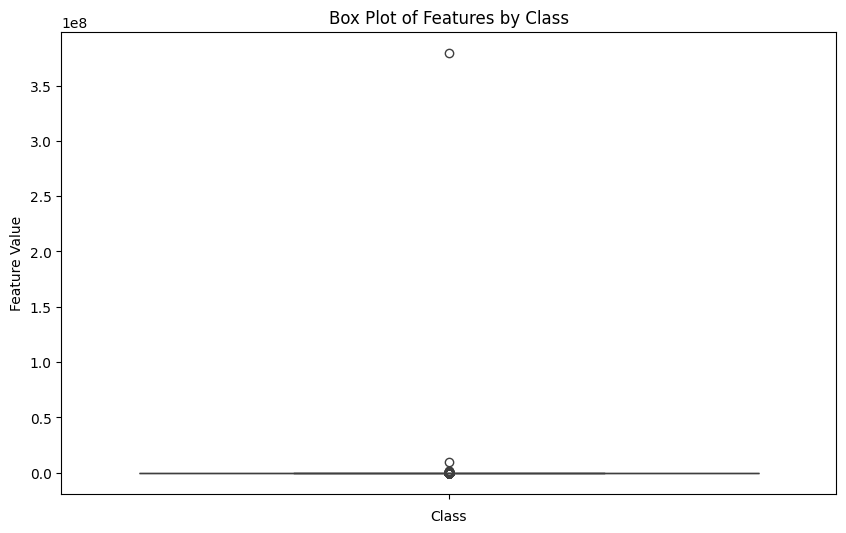

In [71]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='Standard Value', data=filter_df)
plt.title('Box Plot of Features by Class')
plt.xlabel('Class')
plt.ylabel('Feature Value')
plt.show()

In [72]:
filter_df['Standard Value'].max()

379700000.0

In [73]:
filter_df['Standard Value'].min()

0.002

In [85]:
# Initialize an empty list to store the rankings
Standard_Value_threshold = []

# Iterate through the 'Standard Value' column
for i in filter_df['Standard Value']:
    if float(i) > 7:
        Standard_Value_threshold.append("Rank I")
    elif float(i) >= 5:  # This covers the range 5 to 7 (inclusive of 5)
        Standard_Value_threshold.append("Rank II")
    else:  # This covers values less than 5
        Standard_Value_threshold.append("Rank III")

# Optionally, add the rankings to the DataFrame
filter_df['Solubility_Rank'] = Standard_Value_threshold



In [86]:
count_r1=0
for ele in Standard_Value_threshold:
  if ele=="Rank III":count_r1+=1

print(count_r1)

818


In [87]:
Standard_value_class = pd.Series(Standard_Value_threshold, name='Standard_value_class')
final_df = pd.concat([filter_df, Standard_value_class], axis=1)
final_df.head()

,Smiles,Standard Type,Standard Value,Solubility_Rank,Standard_value_class
0,CC(C)C[C@@H]1NC(=O)C(C)(C)NC(=O)[C@H](CCCCCSSc...,IC50,230.0,Rank I,Rank I
1,O=C(Nc1cc(-c2ccccc2)ccc1O)c1ccccc1,IC50,50000.0,Rank I,Rank I
2,C[C@H]1CN(c2ccc(C(=O)Nc3cc(-c4ccccc4)ccc3N)cn2...,IC50,50000.0,Rank I,Rank I
3,Cc1cc(C)c(Nc2ccc(C(=O)N(C)CCCCCCC(=O)NO)cc2)c(...,IC50,35.0,Rank I,Rank I
4,COC(c1ccc(F)cc1)(c1ccc(F)cc1)c1ccc(C(=O)NCCCCC...,IC50,13.0,Rank I,Rank I


In [88]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors

In [90]:
descriptor_names = [desc_name[0] for desc_name in Descriptors._descList] #208, list exists in rdkit, wol wt

calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

def calculate_descriptors(Smiles):
    try:
        mol = Chem.MolFromSmiles(Smiles) # converting smiles to "molecular object"
        if mol is not None:
            return calculator.CalcDescriptors(mol)
        else:
            return [None] * len(descriptor_names)
    except:
        return [None] * len(descriptor_names)

descriptors = filter_df['Smiles'].apply(calculate_descriptors) # applying the function to generate descriptors on the SMILES column in our original dataframe
desc = pd.DataFrame(descriptors.tolist(), columns=descriptor_names) # Adding these descriptors to a new data frame, whose column heading is the descriptor name
results_df = pd.concat([final_df, desc], axis=1) # make a final data frame by joing original df and df of chemical desciptors

Streaming output truncated to the last 5000 lines.
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:52:44] DEPRECATION WARNING: please use MorganGenerator
[04:5

In [91]:
cleaned_final = results_df.dropna()
print(f"Original DataFrame shape: {results_df.shape}")
print(f"Cleaned DataFrame shape: {cleaned_final.shape}")

Original DataFrame shape: (6488, 215)
Cleaned DataFrame shape: (6271, 215)


In [92]:
c=0
check=cleaned_final['Standard_value_class']
for ele in check:
  if ele=='Rank III': c+=1

print(c)

625


In [93]:
cleaned_final.head()

,Smiles,Standard Type,Standard Value,Solubility_Rank,Standard_value_class,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CC(C)C[C@@H]1NC(=O)C(C)(C)NC(=O)[C@H](CCCCCSSc...,IC50,230.0,Rank I,Rank I,13.450481,13.450481,0.167702,-1.237584,0.295108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,O=C(Nc1cc(-c2ccccc2)ccc1O)c1ccccc1,IC50,50000.0,Rank I,Rank I,12.191887,12.191887,0.045335,-0.248971,0.705740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C[C@H]1CN(c2ccc(C(=O)Nc3cc(-c4ccccc4)ccc3N)cn2...,IC50,50000.0,Rank I,Rank I,12.957424,12.957424,0.049385,-0.317974,0.328284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cc1cc(C)c(Nc2ccc(C(=O)N(C)CCCCCCC(=O)NO)cc2)c(...,IC50,35.0,Rank I,Rank I,12.632866,12.632866,0.003616,-0.353767,0.295518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,COC(c1ccc(F)cc1)(c1ccc(F)cc1)c1ccc(C(=O)NCCCCC...,IC50,13.0,Rank I,Rank I,13.653820,13.653820,0.215010,-1.135580,0.141117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [94]:
cleaned_final.shape

(6271, 215)

In [95]:
from sklearn.preprocessing import RobustScaler # robust to outliers
df_robust = cleaned_final.copy()

# numeric columns excluding 'solubility' which is our target column for prediction by model
numeric_columns = df_robust.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = [col for col in numeric_columns if col != 'Standard Value'] # dont scale y!

scaler = RobustScaler()

# scale selected numeric columns
df_robust[numeric_columns] = scaler.fit_transform(df_robust[numeric_columns])

df_robust.head()

,Smiles,Standard Type,Standard Value,Solubility_Rank,Standard_value_class,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CC(C)C[C@@H]1NC(=O)C(C)(C)NC(=O)[C@H](CCCCCSSc...,IC50,230.0,Rank I,Rank I,0.653523,0.653523,0.290267,-1.745525,-0.235181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,O=C(Nc1cc(-c2ccccc2)ccc1O)c1ccccc1,IC50,50000.0,Rank I,Rank I,-0.154309,-0.154309,-0.417769,0.778548,1.143377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C[C@H]1CN(c2ccc(C(=O)Nc3cc(-c4ccccc4)ccc3N)cn2...,IC50,50000.0,Rank I,Rank I,0.337053,0.337053,-0.394340,0.602372,-0.123802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cc1cc(C)c(Nc2ccc(C(=O)N(C)CCCCCCC(=O)NO)cc2)c(...,IC50,35.0,Rank I,Rank I,0.128734,0.128734,-0.659165,0.510988,-0.233802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0
4,COC(c1ccc(F)cc1)(c1ccc(F)cc1)c1ccc(C(=O)NCCCCC...,IC50,13.0,Rank I,Rank I,0.784037,0.784037,0.563998,-1.485095,-0.752152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0


In [96]:
df_robust.shape

(6271, 215)

In [97]:
invalid_count = 0

# Maximum value for float32
float32_threshold = np.finfo(np.float32).max

# Iterate through all rows and columns
rows_to_drop = []

for index, row in df_robust.iterrows():
    for value in row:
        # Check if the value is numeric before applying isinf or comparing thresholds
        if pd.api.types.is_numeric_dtype(type(value)):
            if pd.isnull(value) or np.isinf(value) or abs(value) > float32_threshold:
                rows_to_drop.append(index)
                invalid_count += 1
                break  # Break after marking the row to drop
        else:
            # If it's not numeric, just check for NaN
            if pd.isnull(value):
                rows_to_drop.append(index)
                invalid_count += 1
                break

# Drop rows that contain invalid values
df_robust.drop(rows_to_drop, inplace=True)

# Output the number of invalid entries dropped
print(f"Dropped {invalid_count} invalid entries.")

Dropped 0 invalid entries.


In [98]:
df_robust.shape

(6271, 215)

In [99]:
#spitting into X features and y target for model
y = df_robust['Standard Value']
X = df_robust.drop(columns=['Smiles', 'Standard Value','Standard_value_class'])

In [100]:
print(y.head())
print(X.head())

0      230.0
1    50000.0
2    50000.0
3       35.0
4       13.0
Name: Standard Value, dtype: float64
  Standard Type Solubility_Rank  MaxAbsEStateIndex  MaxEStateIndex  \
0          IC50          Rank I           0.653523        0.653523   
1          IC50          Rank I          -0.154309       -0.154309   
2          IC50          Rank I           0.337053        0.337053   
3          IC50          Rank I           0.128734        0.128734   
4          IC50          Rank I           0.784037        0.784037   

   MinAbsEStateIndex  MinEStateIndex       qed       SPS     MolWt  \
0           0.290267       -1.745525 -0.235181  2.926442  1.144499   
1          -0.417769        0.778548  1.143377 -0.321080 -0.744458   
2          -0.394340        0.602372 -0.123802  0.804047  0.854269   
3          -0.659165        0.510988 -0.233802 -0.232158  0.096672   
4           0.563998       -1.485095 -0.752152 -0.080687  0.681744   

   HeavyAtomMolWt  ...  fr_sulfide  fr_sulfonamd  fr_sul

In [116]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

def select_features(X, y, n_features=25):
    """
    Select the top n features based on their importance using a Random Forest Classifier.

    Parameters:
    X (Pandas DataFrame): Feature matrix.
    y (Pandas Series): Target vector.
    n_features (int): Number of features to select. Default is 25.

    Returns:
    list: List of selected feature names.
    """
    try:
        # Check if X and y are valid
        if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.Series):
            raise ValueError("Invalid input data")

        # Initialize RandomForestClassifier
        rf = RandomForestClassifier(n_estimators=100, random_state=42)

        # Fit the RandomForestClassifier on the entire dataset
        rf.fit(X, y)

        # Get feature importances
        importances = rf.feature_importances_

        # Create a DataFrame to map features to their importances
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        })

        # Sort the features by importance in descending order
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Extract the top n features
        selected_features = importance_df.head(n_features)['Feature'].tolist()

        return selected_features

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
# Create a synthetic dataset
X, y = make_classification(n_samples=100, n_features=30, n_informative=15, n_redundant=5, random_state=42)
X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
y = pd.Series(y)

selected_features = select_features(X, y)
print("Top n features:", selected_features)


Top n features: ['feature_5', 'feature_16', 'feature_21', 'feature_22', 'feature_15', 'feature_28', 'feature_6', 'feature_26', 'feature_0', 'feature_13', 'feature_2', 'feature_10', 'feature_12', 'feature_7', 'feature_29', 'feature_17', 'feature_27', 'feature_24', 'feature_18', 'feature_11', 'feature_1', 'feature_23', 'feature_20', 'feature_4', 'feature_14']


In [117]:
X_selected = pd.DataFrame(X, columns=selected_features)

X_selected.head()

,feature_5,feature_16,feature_21,feature_22,feature_15,feature_28,feature_6,feature_26,feature_0,feature_13,...,feature_17,feature_27,feature_24,feature_18,feature_11,feature_1,feature_23,feature_20,feature_4,feature_14
0,4.074355,4.439858,-2.341301,-2.716396,-4.675277,1.664969,-1.765729,1.018433,1.712668,-0.712838,...,0.229314,-0.588954,0.358544,-0.836107,-1.850632,-1.884786,-0.492755,-0.062665,8.194215,1.108010
1,-0.092132,-0.144503,1.828285,2.763139,2.340286,0.987768,-1.497372,0.671663,-1.527220,1.163858,...,0.105749,2.501370,-1.064562,-0.779656,0.599859,-0.287893,0.424966,-1.417624,5.202060,-0.541698
2,1.276354,0.578461,2.123945,3.904749,2.572695,2.985903,1.361564,1.906379,-0.553192,-1.183261,...,-1.354018,4.211349,-3.005839,1.768772,0.159159,-0.492144,1.754776,0.703642,-7.104065,5.146680
3,1.835629,0.050964,-0.305095,-8.140068,-2.075676,-4.113905,1.103329,-6.083472,-0.956177,3.352424,...,0.033328,-3.792945,-0.368787,0.970393,0.157054,0.803365,0.792935,-2.309184,5.931563,-0.280444
4,2.162078,0.061520,-3.306583,-3.856601,-0.134277,0.155372,-0.315194,1.883654,-1.553584,-0.829946,...,-1.707384,-1.818936,-0.051133,0.635446,0.593927,-1.117418,0.699014,-0.270160,3.657713,-1.247342


In [118]:
data=X_selected.copy()
data['bioactivity_class']=y

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
target = 'bioactivity_class'

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Splitting the data into features (X) and target (y)
X_train = train_data.drop(columns=[target])
y_train = train_data[target]
X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=25, random_state=42)

# Fitting the model on the training data
rf_classifier.fit(X_train, y_train)

# Making predictions on the test data
y_pred = rf_classifier.predict(X_test)

y_train_pred=rf_classifier.predict(X_train)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.67      0.60      0.63        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20

Confusion Matrix:
[[7 3]
 [4 6]]


In [120]:
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Splitting the data into features (X) and target (y)
X_train = train_data.drop(columns=[target])
y_train = train_data[target]
X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# Initializing the Random Forest Classifier with adjustments
rf_classifier = RandomForestClassifier(
    n_estimators=150,          # Increase number of trees
    max_depth=8,              # Limit maximum depth of trees
    min_samples_split=5,       # Minimum samples to split a node
    min_samples_leaf=3,        # Minimum samples at a leaf node
    random_state=42,
    max_features='sqrt'
)

# Fitting the model on the training data
rf_classifier.fit(X_train, y_train)

# Making predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, you can also evaluate training predictions
y_train_pred = rf_classifier.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.70      0.67        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20

Confusion Matrix:
[[6 4]
 [3 7]]
Training Accuracy: 1.0


In [122]:
# Print classification report
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



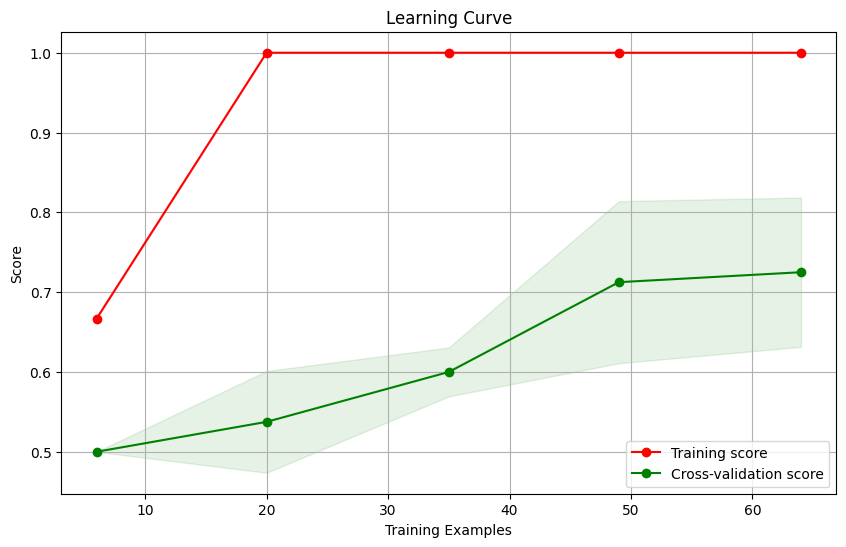

In [123]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    # Calculate learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    # Mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plot learning curve for the RandomForestClassifier
plot_learning_curve(rf_classifier, X_train, y_train)

In [136]:
!pip install lazypredict
import sklearn
print(sklearn.__version__)
!pip install --upgrade lazypredict
!pip install scikit-learn==1.1.3



1.5.2
